# **Desafio prático - Classificação de dados com a competição do Titanic**

![](https://media.giphy.com/media/Uj3SeuVfg2oCs/giphy.gif)

O problema de classificação que iremos resolver é o descrito na competição do Kaggle [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). Esse desafio é muito famoso e utilizado por quem está começando na área de Data Science e/ou a participar de competições pelo Kaggle (apesar de ser um assunto #badvibes).

![](https://media.giphy.com/media/4ryp9Ihw0BEyc/giphy.gif)

O objetivo da competição é simples: **criar um modelo utilizando Machine Learning para predizer se um passageiro do Titanic sobreviveu ou não ao naufrágio**.

## **Bibliotecas auxiliares**

Aqui nós vamos importar as algumas das bibliotecas necessárias para fazer a análise e visualização dos dados (lembram dessas aulas?)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Conhecendo nossos conjuntos de dados**

In [0]:
# esse conjunto que o Kaggle chama de teste não será usado dessa forma porque ele não 
# contém a classe dos exemplos e, dessa forma, não podemos avaliar o modelo com ele.
# para a avaliação, vamos separar o conjunto inicial que vamos chamar de "df" entre treino e teste
# e fazer as predições para submeter para o Kaggle com o conjunto chamado de "submission"
df = pd.read_csv('train.csv')
submission = pd.read_csv('test.csv')

Vamos ver a carinha dos nossos conjuntos de dados?

In [3]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
submission.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


Na tabela abaixo podemos conferir o significado de cada um dos atributos presentes no conjunto de dados:

|Atributo| Descrição|
|--------|----------|
|**PassengerId**| id do passageiro|
|**Pclass**| classe do ticket|
|**Name**|nome do passageiro|
|**Sex**|gênero do passageiro|
|**Age**|idade do passageiro (em anos)|
|**SibSp**|Quantidade de irmãos/cônjuge que também embarcaram no Titanic|
|**Parch**|Quantidade de pais/filhos que também embarcaram no Titanic|
|**Ticket**|Número do ticket do passageiro|
|**Fare**|Tarifa paga pelo passageiro|
|**Cabin**|Número da cabine|
|**Embarked**|Porto de embarque (C = Cherbourg, Q = Queenstown e S = Southampton)|
|**Survived**|Indica se o passageiro sobreviveu ou não ao naufrágio (é o nosso target)|


Vamos verificar o tamanho dos conjuntos de dados e o que iremos submeter no Kaggle?

In [5]:
df.shape

(891, 12)

In [6]:
submission.shape

(418, 11)

Vamos ver os tipos dos dados do conjunto de dados (também podemos verificar a quantidade de valores faltantes para cada atributo)?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **Remoção de features irrelevantes**

Algumas features presentes em nosso conjunto de dados não são úteis para nos ajudar a predizer se um passageiro sobreviveu ou não ao naufrágio do Titanic. Essas features geralmente estão relacionadas a identificadores únicos de um indivíduo e, portanto, não ajudam na generalização do modelo.

Que features seriam essas?

- IDs (identificadores únicos em uma tabela no banco de dados, por exemplo) 
- Números de documento (um CPF ou RG se enquadraria nesse caso)
- Nomes, telefones, e-mail, etc... Tudo que for específico para uma determinada pessoa não deve ser fornecido para o modelo.

In [0]:
def count_unique(df):
  print("Quantidade de valores únicos para cada feature")
  for i in df.columns:
    print(f"{i}: {df[i].nunique()}")

In [9]:
count_unique(df)

Quantidade de valores únicos para cada feature
PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 88
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 147
Embarked: 3


Podemos remover esses casos que não fazem sentido do nosso conjunto de dados:

In [0]:
columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']

df = df.drop(columns, axis=1)

In [11]:
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


In [12]:
df.shape

(891, 8)

### **Análise exploratória (Exploratory Data Analysis - EDA)**

Antes de treinarmos nosso modelo, precisamos fazer uma análise dos nossos dados para entender o nosso conjunto de dados e verificar quais atributos fazem sentido e verificar se alguma transformação será necessária.

### Survived (Sobrevivência do passageiro)

Primeiramente, é interessante olharmos a proporção do nosso target no nosso conjunto de dados:

In [13]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Os passageiros com o target igual a 0 são aqueles que não sobreviveram ao naufrágio, enquanto que os que sobreviveram estão com o valor 1 no target.

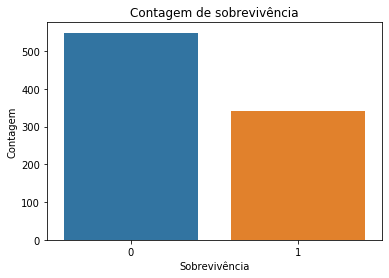

In [14]:
sns.countplot(data=df, x = 'Survived')
plt.title("Contagem de sobrevivência")
plt.xlabel('Sobrevivência')
plt.ylabel('Contagem')
plt.show()

In [15]:
print(f"Considerando nosso conjunto de dados, {df.Survived.value_counts()[0]/df.shape[0]*100:.2f}% dos passageiros não sobreviveram ao naufrágio :(")

Considerando nosso conjunto de dados, 61.62% dos passageiros não sobreviveram ao naufrágio :(


###  Pclass (classe do ticket do passageiro) 	 	 	 	 	 	

 De acordo com a descrição das features no Kaggle, os valores para esse atributo têm os seguintes significados:
 - 1 - Classe alta
 - 2 - Classe média
 - 3 - Classe baixa

 Contando a quantidade de exemplos de cada uma dessas classes, podemos observar que a maioria dos passageiros era de classe baixa:

In [16]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Podemos agora comparar a classe dos passageiros com relação ao nosso target para verificar se ela é relevante:

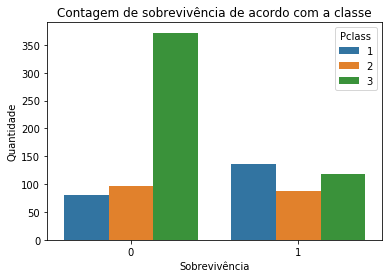

In [17]:
p = sns.countplot(data=df, x = 'Survived', hue = 'Pclass')
plt.title("Contagem de sobrevivência de acordo com a classe")
plt.xlabel("Sobrevivência")
plt.ylabel("Quantidade")
plt.show()

In [18]:
# proporção de sobrevivência por classe
df[["Pclass", "Survived"]].groupby(['Pclass']).mean()*100

,Survived
Pclass,
1,62.962963
2,47.282609
3,24.236253


Apesar dos passageiros da terceira classe serem os mais numerosos, podemos observar tanto pela contagem de sobrevivência quanto pela proporção que esses passageiros foram os que menos sobreviveram, enquanto que os passageiros da primeira classe foram os que mais sobreviveram.

###  Sex (gênero do passageiro) 	 	 	 	

Com relação ao gênero, podemos observar que a maioria dos passageiros eram homens:

In [19]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

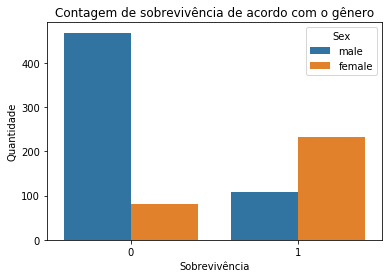

In [20]:
p = sns.countplot(data=df, x = 'Survived', hue = 'Sex')
plt.title("Contagem de sobrevivência de acordo com o gênero")
plt.xlabel("Sobrevivência")
plt.ylabel("Quantidade")
plt.show()

In [21]:
# proporção de sobrevivência por gênero
df[["Sex", "Survived"]].groupby(['Sex']).mean()*100

,Survived
Sex,
female,74.203822
male,18.890815


Aqui também podemos observar uma situação similar ao que ocorreu com a classe: os passageiros do gênero masculino, apesar de mais numerosos, tiveram uma baixa proporção de sobrevivência quando comparamos com as mulheres.

Uma outra análise interessante de ser realizada é observar as taxas de sobrevivência dependendo do gênero e também da classe:

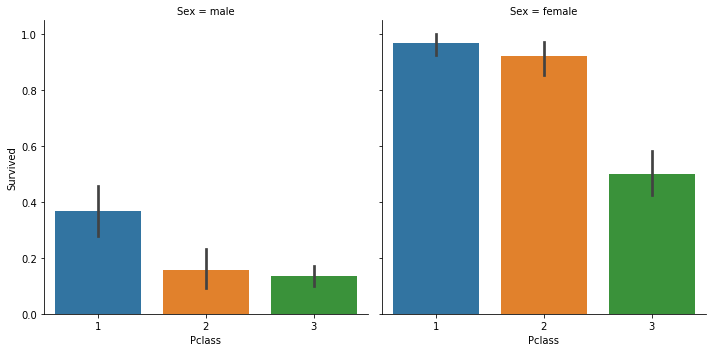

In [22]:
sns.catplot(x="Pclass", y="Survived", col="Sex", data=df,kind="bar");

O gráfico acima nos permite observar que tanto para homens quanto para mulheres houve uma maior sobrevivência para os passageiros da primeira classe. Ele também nos permite observar que a taxa de sobrevivência das mulheres da terceira classe é mais próxima da taxa de sobrevivência dos homens da primeira classe do que das mulheres da primeira e segunda classe.

###  Age (idade do passageiro) 	 	

Observando a descrição abaixo, vemos que, na média, os passageiros tinham em torno de 30 anos:

In [23]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

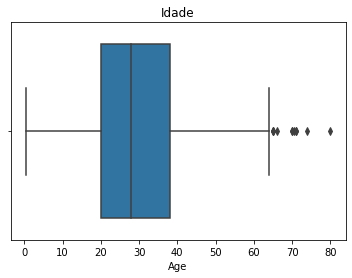

In [24]:
_ = sns.boxplot(df['Age']).set_title("Idade")

Podemos checar também a distribuição das idades por sobrevivência. Se tentarmos ver a distribuição da idade do jeito como nosso dado está, teremos um erro porque a idade tem valores nulos. Para fazer a distribuição, temos duas alternativas:
- Ignorar os nulos e ver a distribuição da idade só para os passageiros que possuem essa informação
- Substituir os valores faltantes por algum número (0, média ou mediana da idade, por exemplo)

Aqui vamos só ignorar os nulos:



In [0]:
survived_age_not_null = df.loc[(df.Survived == 1) & (df.Age.isnull()==False), 'Age']
not_survived_age_not_null = df.loc[(df.Survived == 0) & (df.Age.isnull()==False), 'Age']

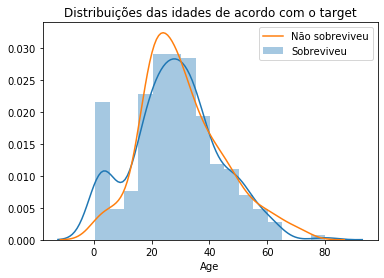

In [26]:
sns.distplot(survived_age_not_null, hist=True, label='Sobreviveu')
sns.distplot(not_survived_age_not_null, hist=False, label='Não sobreviveu')
_ = plt.title("Distribuições das idades de acordo com o target")

Se fizermos as distribuições das idades entre os passageiros que sobreviveram ou não, podemos notar que há pico de sobrevivência para os passageiros com menos de 10 anos, indicando que crianças tiveram mais chances de sobreviverem ao naufrágio do que adultos.

### **Tarefinha pra casa**

![](https://media.giphy.com/media/geONXs3YIr0Aw/giphy.gif)

Por conta do tempo, não vamos conseguir fazer a análise de todas as features :(

Então sugerimos que vocês façam a análise das features que ficaram faltando:
- Fare
- Embarked
- SibSp
- Parch

Algumas ideias de análises que podem ser feitas:
- Comparar a tarifa paga pelo passageiro dependendo de sua classe
- Analisar se o tamanho da família influenciou na sobrevivência (o tamanho da família pode ser dado pela soma das features `SibSp` e `Parch`)
- Analisar se há diferença da tarifa paga dependendo do porto de embarque
- Verificar a correlação entre as features utilizando um heatmap

## Feature Engineering

Alguns algoritmos exigem que algumas transformações sejam feitas para que possamos treinar o modelo...

![alt text](http://giphygifs.s3.amazonaws.com/media/720g7C1jz13wI/giphy.gif)

Algumas dessas transformações são:
- Converter features categóricas em numéricas
- Fazer normalização ou estandardização dos dados
- Fazer o tratamento de valores faltantes
- Etc...

Como exemplo, vamos fazer a conversão de features categóricas e o tratamento de valores faltantes:

#### **Tratamento de valores faltantes (missing values)**

Como pudemos observar nas descrições acima, há casos de passageiros sem informação sobre suas idades. Podemos substituir esses valores faltantes pela mediana das idades:

In [0]:
median_age = df['Age'].median() 

In [0]:
df.loc[df['Age'].isnull(), 'Age'] = median_age

Que outras abordagens poderíamos adotar para realizar essa substituição de valores faltantes?

- Poderíamos ter analisado a idade de homens e mulheres e substituir pela mediana dependendo do gênero do passageiro
- Poderíamos substituir pela média da idade ao invés da mediana (tomar cuidado com outliers nesse caso!)

#### **Conversão de features categóricas**

A feature que indica o gênero dos passageiros é categórica. Iremos transformá-la em uma feature numérica. Há diversas abordagens para realizar essa transformação:
- Uma delas é utilizando o [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

- E outra delas é fazendo o [One-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

Por exemplo, se tivéssemos a seguinte feature:

|renda|
|-----|
|alta |
|baixa|
|media|
|alta |

Com o LabelEncoder, teríamos o seguinte resultado:

|renda|
|-----|
|0 |
|1|
|2|
|0 |

Já com o One-hot encoding teríamos o seguinte resultado:

|renda_alta|renda_baixa|renda_media|
|-----|----|----|
|1 |0|0|
|0|1|0|
|0|0|1|
|1 |0|0|

No nosso caso, vamos utilizar o LabelEncoder:


In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'])

# ao invés do LabelEncoder, também poderíamos ter feito só um map e passar as transformações que queríamos:
# df['Sex'] = df['Sex'].map( {'female': 0, 'male': 1})

In [30]:
df['Sex'].value_counts()

1    577
0    314
Name: Sex, dtype: int64

Se a gente comparar essas quantidades com o que tínhamos na feature _Sex_, as substituições foram feitas da seguinte maneira:
- Se o gênero do passageiro fosse feminino, a feature _Sex_ ficaria com valor 0
- Se o gênero do passageiro fosse masculino, a feature _Sex_ ficaria com valor 1

### **Tarefinha pra casa**

![](https://media.giphy.com/media/geONXs3YIr0Aw/giphy.gif)

**Que outras transformaçõs poderíamos fazer em nosso conjunto de dados?**
- Criar categorias para a idade (criança, adulto, idoso, por exemplo)
- Criar uma feature para indicar o tamanho da família (soma das features `SibSp` e `Parch`)
- [Aqui](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/) também algumas ideias de feature engineering para esse desafio

Tentem fazer algumas dessas transformações ou fazer outras que vocês acreditam que façam sentido :D 

## Treinamento
Agora que nosso conjunto de dados está bonitinho, vamos treinar o nosso primeiro modelo \o/

Antes de treinar o modelo, precisamos separar as features do nosso target (**tomar muito cuidado para não treinar o modelo com ele!!!**). 

Além disso, nessa primeira versão, vamos utilizar somente as 3 features que analisamos na aula:

In [0]:
# nossas features
x = df[['Age', 'Sex', 'Pclass']]

# nosso target
y = df['Survived']

Uma outra coisa que precisamos fazer antes de treinar o modelo é separar o nosso conjunto de dados entre o **conjunto de treinamento** e o **conjunto de teste**. No nosso caso, vamos usar 75% do conjunto para treinamento e o restante para teste:

In [0]:
from sklearn.model_selection import train_test_split

# Separando os dados em treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [33]:
x_train.shape

(668, 3)

In [34]:
x_test.shape

(223, 3)


Esse nosso primeiro modelo será uma Árvore de decisão. O scikit-learn já contém uma implementação dela [aqui](https://scikit-learn.org/stable/modules/tree.html).



In [35]:
from sklearn.tree import DecisionTreeClassifier

# Instanciando o classificador
model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Treinamento do modelo
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

**UHULLLLL! Temos nosso primeiro modelo de classificação \o/**

![](https://media.giphy.com/media/OU1marLMNNtnO/giphy.gif)

Vamos ver a carinha dela (esse código para visualização da árvore nós encontramos [aqui](https://www.kaggle.com/jlawman/complete-beginner-your-first-titanic-submission))? :)

In [0]:
# arquivo de texto que armazena a estrutura da nossa árvore de decisão
from sklearn.tree import export_graphviz
export_graphviz(model,out_file='titanic_tree.dot',feature_names=['Age', 'Sex', 'Pclass'],rounded=True,filled=True,class_names=['Não sobreviveu','Sobreviveu'])


In [0]:
!dot -Tpng titanic_tree.dot -o titanic_tree.png

Após converter o arquivo de texto, podemos visualizar a árvore abaixo. As cores ajudam a identificar a classificação dada pelo modelo:

- Nós ou folhas em laranja significam que a nossa árvore de decisão acredita que o passageiro **NÃO SOBREVIVEU**
- Já nos nós e folhas em azul, a árvore acha que o passageiro **SOBREVIVEU**

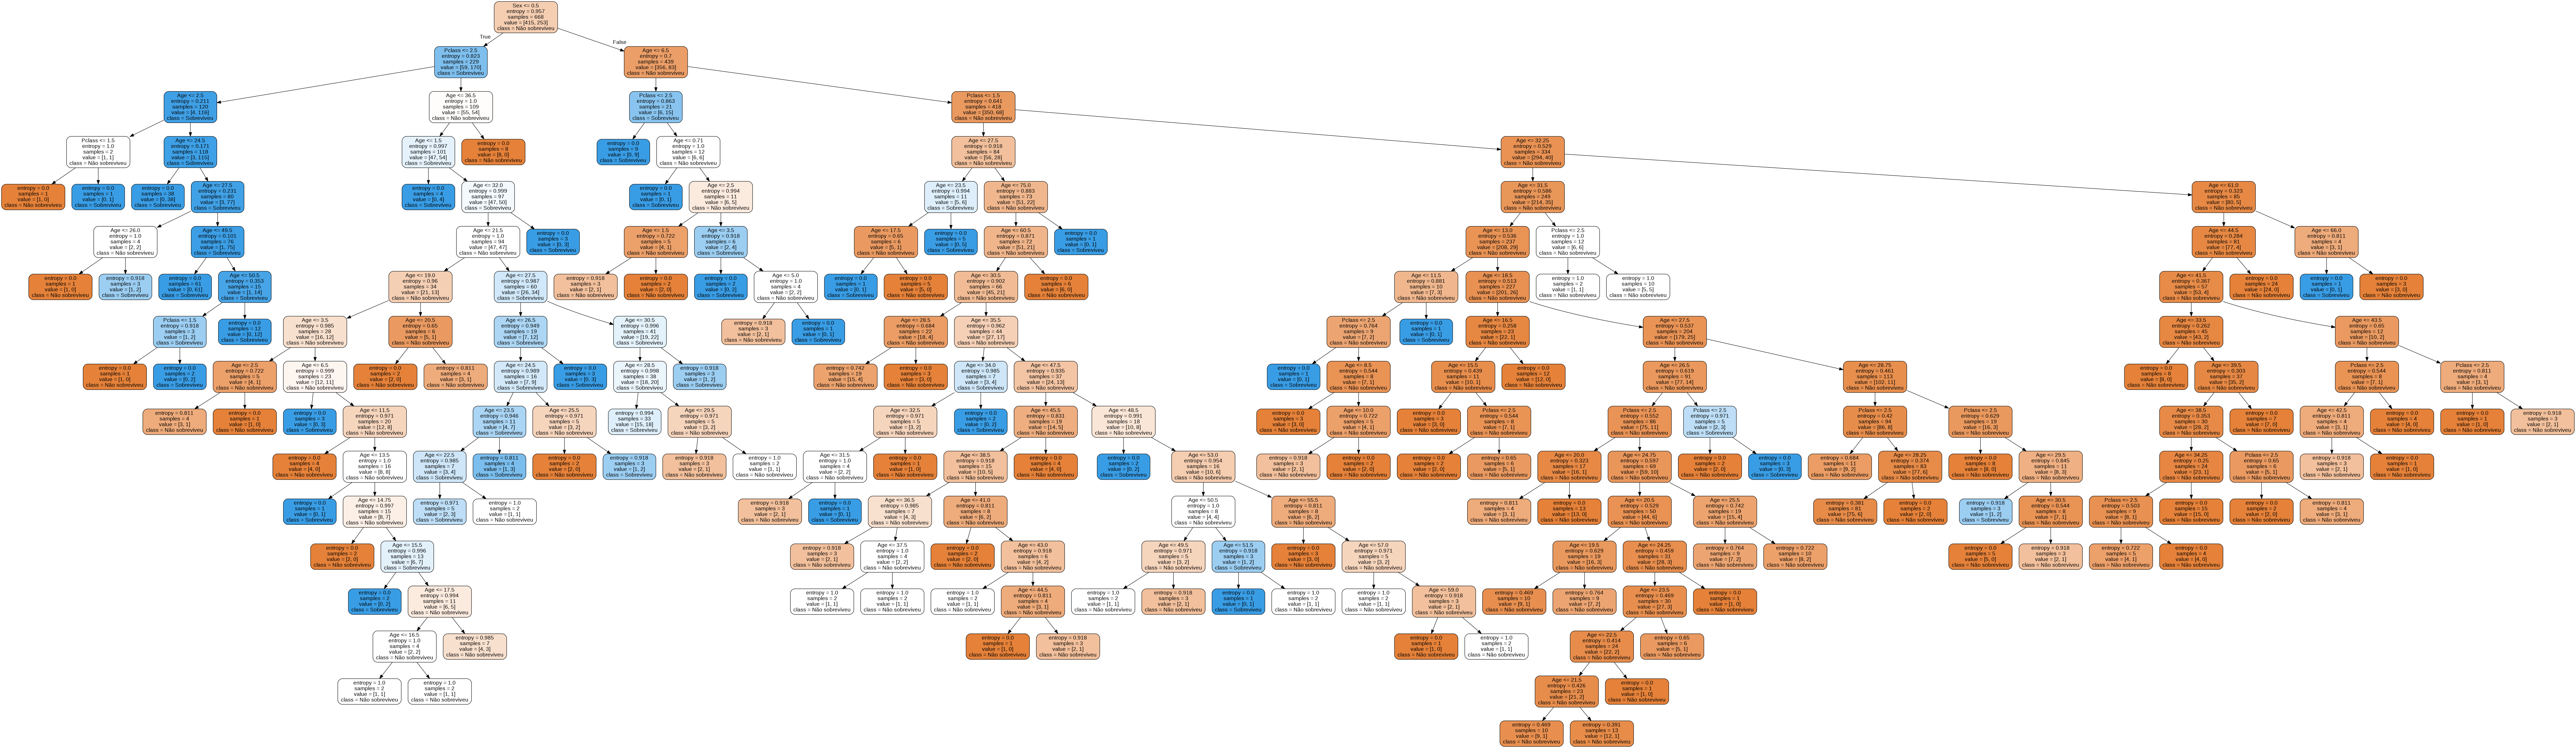

In [38]:
from IPython.core.display import Image, display
display(Image('titanic_tree.png', width=1900, unconfined=True))

**O que vocês acharam dessa árvore?**

Está bem complexa né? Vamos voltar nesse assunto daqui a pouco :)

## Avaliando nosso modelo

Agora precisamos avaliar se o modelo está bom ou não!

Para isso, precisamos utilizá-lo para realizar as predições para nosso conjunto de teste:

In [0]:
y_pred = model.predict(x_test)

Como a métrica de avaliação do Kaggle é a acurácia, vamos utilizá-la primeiro:

In [0]:
from sklearn.metrics import accuracy_score

In [41]:
accuracy_score(y_test, y_pred)

0.7623318385650224

De todas as predições que nosso modelo fez, ele acertou em 76,23% dos casos.

Outra avaliação que poderíamos fazer é utilizando uma matriz de confusão:

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
# plota a matriz de confusão. Código retirado da documentação do próprio Sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5) 

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe real')
    plt.xlabel('Classe prevista')
    plt.tight_layout()

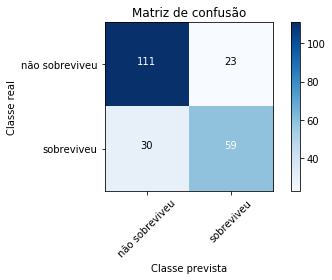

In [44]:
cnf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cnf_matrix, classes=[ 'não sobreviveu', 'sobreviveu'])

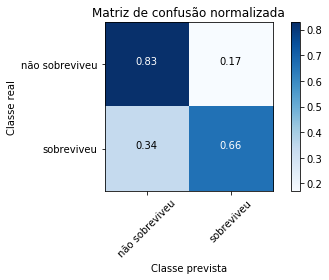

In [45]:
plot_confusion_matrix(cnf_matrix, normalize=True, classes=[ 'não sobreviveu', 'sobreviveu'], title='Matriz de confusão normalizada')

Pela matriz de confusão acima, podemos notar que nosso modelo se confundiu mais para 34% dos passageiros que sobreviveram, predizendo que eles não haviam sobrevivido.

## Predição


Agora que nosso modelo foi avaliado, vamos fazer as predições para o conjunto sem o target e fazer a [submissão para o Kaggle](https://www.kaggle.com/c/titanic/submit)? :D

![alt text](https://media.giphy.com/media/l4JySAWfMaY7w88sU/giphy.gif)

Antes de fazer as predições, precisamos fazer as mesmas transformações que fizemos no conjunto de treinamento durante a etapa de feature engineering:

In [0]:
# substituímos os valores faltantes pela mediana da idade do conjunto de treinamento
submission.loc[submission['Age'].isnull(), 'Age'] = median_age

In [0]:
# utilizamos o encoder que foi criado com base no conjunto de treinamento
# como o LabelEncoder já "aprendeu" com o conjunto de treinamento como substituir esses valores,
# a gente usa só o transform e não fit_transform como fizemos na feature engineering 
submission['Sex'] = encoder.transform(submission['Sex'])

In [0]:
# realiza a predição para o conjunto de submissão do Kaggle
result = model.predict(submission[['Age', 'Sex', 'Pclass']])

In [49]:
result

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

Para a submissão no Kaggle, além da predição, precisamos fornecer também o ID do passageiro:

In [0]:
# transformar o array em um DataFrame para concatenarmos como ID
results = pd.DataFrame(list(result), columns=['Survived'])

In [51]:
submission = pd.concat([submission['PassengerId'], results],axis=1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1


In [0]:
submission.to_csv("titanic_submission.csv", index=False)

Se todas fizemos tudo igualzinho, a acurácia que obtivemos no nosso modelo inicial foi de **0.68421**

Se observarmos o resultado da acurácia no conjunto de treinamento, tivemos uma certa diminuição na acurácia do conjunto de teste. Por que isso ocorre?

 ![](https://hackernoon.com/hn-images/1*SBUK2QEfCP-zvJmKm14wGQ.png)

  
No nosso caso, o modelo sofreu **overfitting**. Isso também explica a alta complexidade da árvore. No caso da nossa árvore, é necessário podá-la para que ela possa **generalizar** o problema.

## Próximos passos

Ainda podemos melhorar **MUITO** o nosso modelo :) 

O que podemos fazer?

- Como pudemos ver, nossa árvore está sofreu overfitting. Podemos mudar diversos parâmetros da nossa árvore para evitar que isso aconteça. Alguns parâmetros que podemos alterar:
  - **max_depth** (profundidade máxima da árvore) - podemos determinar um valor para que ela não se aprofunde demais
  - **min_samples_split** (número mínimo de exemplos para dividir um nó interno) - podemos aumentar o número (o mínimo *default* é 2) para diminuir o número de divisões
  - **min_samples_leaf** (número mínimo de exemplos para que um nó seja uma folha) - podemos aumentar o número (o mínimo *default* é 1) para diminuir o número de folhas
- Podemos realizar outras transformações na etapa de feature engineering ou criar novas features
- Também podemos treinar o modelo adicionando as outras features que não vimos nessa aula. Talvez elas possam ajudar na predição ;)
- Além disso, é interessante ver as outras métricas de avaliação para entendermos melhor o nosso modelo e como podemos melhorá-lo!

### **Tarefinha pra casa**

![](https://media.giphy.com/media/geONXs3YIr0Aw/giphy.gif)


Tentem fazer algumas (ou todas) as sugestões feitas nesse notebook e fazer a submissão das predições no Kaggle novamente!  

Na próxima aula vocês nos contam se a acurácia do modelo melhorou :D 

![](https://media.giphy.com/media/3o7budMRwZvNGJ3pyE/giphy.gif)